**Goals of this notebook:**
    * Cross-Validate m_full (takes into consideration trend, seasonality and remainders)
    * Test m_full with the df_test
    * Generate a new dataframe for October 2021 and calculate the R2 score for y_pred and y_true

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from datetime import datetime, date, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import AutoReg

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

### 1. Load and inspect the data

In [2]:
#Load the complete df_train
with open('./data/df_trend_season_lags.bin', 'rb') as f:
    df_train = pickle.load(f)

In [3]:
df_train.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,
1957-09-04,12.6,3,0,0,0,0,0,0,0,1,0,0,0,13.691262,-1.091262,-1.391185,-0.491109,0.708967,12.585588
1957-09-05,16.4,4,0,0,0,0,0,0,0,1,0,0,0,13.691338,2.708662,-1.091262,-1.391185,-0.491109,12.954146
1957-09-06,15.8,5,0,0,0,0,0,0,0,1,0,0,0,13.691414,2.108586,2.708662,-1.091262,-1.391185,16.279885
1957-09-07,20.6,6,0,0,0,0,0,0,0,1,0,0,0,13.691491,6.908509,2.108586,2.708662,-1.091262,14.979969
1957-09-08,14.2,7,0,0,0,0,0,0,0,1,0,0,0,13.691567,0.508433,6.908509,2.108586,2.708662,19.743151


In [4]:
#Load the df_test
with open('./data/df_test.bin', 'rb') as f:
    df_test = pickle.load(f)

In [5]:
df_test.head()

,TG,timestep,trend,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
2021-10-01,13.1,23406,11.286326,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-02,15.2,23407,11.286413,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-03,17.5,23408,11.286500,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-04,13.2,23409,11.286587,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-05,12.6,23410,11.286674,10,0,0,0,0,0,0,0,0,1,0,0


In [6]:
#Load the trend_seasonal model
with open('./data/m_trend_seasonal.bin', 'rb') as f:
    m_trend_seasonal = pickle.load(f)

In [7]:
#Load the full model
with open('./data/m_full.bin', 'rb') as f:
    m_full = pickle.load(f)

In [8]:
#Create X_full and y_full from df_train
X_train = df_train.drop(columns=['TG', 'trend_seasonal', 'remainder', "predictions_full_model"])
y_train = df_train['TG']

In [9]:
X_train.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
1957-09-04,3,0,0,0,0,0,0,0,1,0,0,0,-1.391185,-0.491109,0.708967
1957-09-05,4,0,0,0,0,0,0,0,1,0,0,0,-1.091262,-1.391185,-0.491109
1957-09-06,5,0,0,0,0,0,0,0,1,0,0,0,2.708662,-1.091262,-1.391185
1957-09-07,6,0,0,0,0,0,0,0,1,0,0,0,2.108586,2.708662,-1.091262
1957-09-08,7,0,0,0,0,0,0,0,1,0,0,0,6.908509,2.108586,2.708662


In [10]:
# Test the R2 score of X_full and y_full
m_full.score(X_train, y_train)

0.889344633360281

### 1. Cross-Validate the model

In [11]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [12]:
# Create the time series split
time_series_split = ts_split.split(X_train, y_train)

In [13]:
result = cross_val_score(estimator=m_full,
                         X=X_train, y=y_train,
                         cv=time_series_split)
result

array([0.88710802, 0.8836552 , 0.87552832, 0.90534916, 0.89546139])

In [14]:
result.mean()

0.8894204165423657

### 2. Use df_test to validate the model

In [15]:
df_test.head()

,TG,timestep,trend,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
2021-10-01,13.1,23406,11.286326,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-02,15.2,23407,11.286413,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-03,17.5,23408,11.286500,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-04,13.2,23409,11.286587,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-05,12.6,23410,11.286674,10,0,0,0,0,0,0,0,0,1,0,0


In [16]:
df_test.drop(columns=['trend', 'month'], inplace=True)

In [17]:
X_test = df_test.drop(columns=['TG'])

#### 2.1 Generate the 'trend_seasonal' data

In [18]:
df_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)
df_test.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,
2021-10-01,13.1,23406,0,0,0,0,0,0,0,0,1,0,0,11.495792
2021-10-02,15.2,23407,0,0,0,0,0,0,0,0,1,0,0,11.495868
2021-10-03,17.5,23408,0,0,0,0,0,0,0,0,1,0,0,11.495944
2021-10-04,13.2,23409,0,0,0,0,0,0,0,0,1,0,0,11.496021
2021-10-05,12.6,23410,0,0,0,0,0,0,0,0,1,0,0,11.496097


<AxesSubplot:xlabel='DATE'>

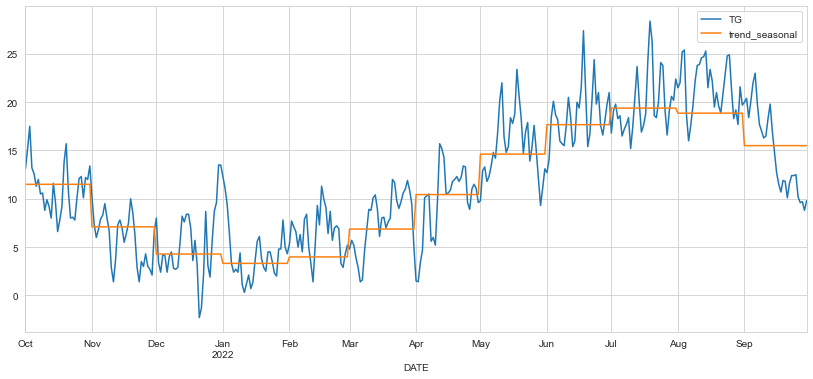

In [19]:
df_test[['TG', 'trend_seasonal']].plot()

#### 2.2 Calculate the 'remainder'

In [20]:
df_test['remainder'] = df_test['TG'] - df_test['trend_seasonal']
df_test.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,
2021-10-01,13.1,23406,0,0,0,0,0,0,0,0,1,0,0,11.495792,1.604208
2021-10-02,15.2,23407,0,0,0,0,0,0,0,0,1,0,0,11.495868,3.704132
2021-10-03,17.5,23408,0,0,0,0,0,0,0,0,1,0,0,11.495944,6.004056
2021-10-04,13.2,23409,0,0,0,0,0,0,0,0,1,0,0,11.496021,1.703979
2021-10-05,12.6,23410,0,0,0,0,0,0,0,0,1,0,0,11.496097,1.103903


#### 2.3 Add the 'lag'

In [21]:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2021-10-01,13.1,23406,0,0,0,0,0,0,0,0,1,0,0,11.495792,1.604208,NaN,NaN,NaN
2021-10-02,15.2,23407,0,0,0,0,0,0,0,0,1,0,0,11.495868,3.704132,1.604208,NaN,NaN
2021-10-03,17.5,23408,0,0,0,0,0,0,0,0,1,0,0,11.495944,6.004056,3.704132,1.604208,NaN
2021-10-04,13.2,23409,0,0,0,0,0,0,0,0,1,0,0,11.496021,1.703979,6.004056,3.704132,1.604208
2021-10-05,12.6,23410,0,0,0,0,0,0,0,0,1,0,0,11.496097,1.103903,1.703979,6.004056,3.704132


In [22]:
df_test.loc['2021-10-01', 'lag1'] = df_train.loc['2021-09-30', 'remainder']
df_test.loc['2021-10-02', 'lag2'] = df_train.loc['2021-09-30', 'remainder']
df_test.loc['2021-10-03', 'lag3'] = df_train.loc['2021-09-30', 'remainder']

In [23]:
df_test.loc['2021-10-01', 'lag2'] = df_train.loc['2021-09-30', 'lag1']
df_test.loc['2021-10-02', 'lag3'] = df_train.loc['2021-09-30', 'lag1']

In [24]:
df_test.loc['2021-10-01', 'lag3'] = df_train.loc['2021-09-30', 'lag2']

In [25]:
df_test.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2021-10-01,13.1,23406,0,0,0,0,0,0,0,0,1,0,0,11.495792,1.604208,-4.376473,-4.076397,-2.876320
2021-10-02,15.2,23407,0,0,0,0,0,0,0,0,1,0,0,11.495868,3.704132,1.604208,-4.376473,-4.076397
2021-10-03,17.5,23408,0,0,0,0,0,0,0,0,1,0,0,11.495944,6.004056,3.704132,1.604208,-4.376473
2021-10-04,13.2,23409,0,0,0,0,0,0,0,0,1,0,0,11.496021,1.703979,6.004056,3.704132,1.604208
2021-10-05,12.6,23410,0,0,0,0,0,0,0,0,1,0,0,11.496097,1.103903,1.703979,6.004056,3.704132


#### 2.4 Calculate R2 score for df_test

In [26]:
X_test = df_test.drop(columns=['TG', 'trend_seasonal', 'remainder'])
y_test = df_test['TG']

In [27]:
m_full.score(X_test, y_test)

0.8946906051112375

#### 2.5 Merge df_train and df_test

In [28]:
X_test.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
2021-10-01,23406,0,0,0,0,0,0,0,0,1,0,0,-4.376473,-4.076397,-2.876320
2021-10-02,23407,0,0,0,0,0,0,0,0,1,0,0,1.604208,-4.376473,-4.076397
2021-10-03,23408,0,0,0,0,0,0,0,0,1,0,0,3.704132,1.604208,-4.376473
2021-10-04,23409,0,0,0,0,0,0,0,0,1,0,0,6.004056,3.704132,1.604208
2021-10-05,23410,0,0,0,0,0,0,0,0,1,0,0,1.703979,6.004056,3.704132


In [29]:
df_test['predictions_full_model'] = m_full.predict(X_test)

In [30]:
# Create the complete dataset and plot it
df_full = df_train[['TG', 'trend_seasonal', 'predictions_full_model']].append(df_test[['TG', 'trend_seasonal', 'predictions_full_model']])

/var/folders/tr/90xr4qzn78v1dd60234t4jxr0000gn/T/ipykernel_81608/8618755.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_train[['TG', 'trend_seasonal', 'predictions_full_model']].append(df_test[['TG', 'trend_seasonal', 'predictions_full_model']])


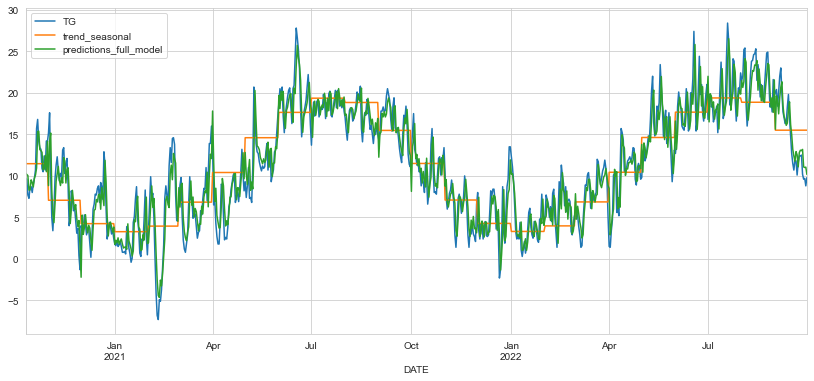

In [31]:
df_full.iloc[-720:,:].plot();

### 3. Predictions into the future

#### 3.1 Create manually a dataframe for the 1st of October

In [32]:
# Combine df_train and df_test
df_com = df_train.append(df_test)

/var/folders/tr/90xr4qzn78v1dd60234t4jxr0000gn/T/ipykernel_81608/3339700566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_com = df_train.append(df_test)


In [33]:
X_combined = df_com.drop(columns=['TG', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = df_com['TG']

In [34]:
# Train a model on the combined data
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [35]:
timestep = df_com['timestep'].max() + 1
months = [0] * 8 + [1] + [0] * 2
lag1 = df_com.loc['2022-09-30', 'remainder']
lag2 = df_com.loc['2022-09-30', 'lag1']
lag3 = df_com.loc['2022-09-30', 'lag2']

In [36]:
X_future = [timestep]
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)

In [37]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

In [44]:
print(f"The predicted temperature for the 01.10. is {round(m_combined.predict(X_future)[0], 1)}")

The predicted temperature for the 01.10. is 7.3


#### 3.2 Create a function that generates dataframes for the future

In [46]:
def create_future_dataframe(past_dataframe, no_of_months):

    month_duration = {
        "1": "31",
        "2": "28",
        "3": "31",
        "4": "30",
        "5": "31",
        "6": "30",
        "7": "31",
        "8": "31",
        "9": "30",
        "10": "31",
        "11": "30",
        "12": "31"
    }

    month_ohe = {
        "1": [0] * 11,
        "2": [1] + [0] * 10,
        "3": [0] + [1] + [0] * 9,
        "4": [0] * 2 + [1] + [0] * 8,
        "5": [0] * 3 + [1] + [0] * 7,
        "6": [0] * 4 + [1] + [0] * 6,
        "7": [0] * 5 + [1] + [0] * 5,
        "8": [0] * 6 + [1] + [0] * 4,
        "9": [0] * 7 + [1] + [0] * 3,
        "10":[0] * 8 + [1] + [0] * 2,
        "11":[0] * 9 + [1] + [0],
        "12":[0] * 10 + [1]
    }


    df = past_dataframe.drop(["TG", "trend_seasonal", "predictions_full_model", "remainder"], axis=1)

    last_day_past_df = past_dataframe.iloc[-1:,:].index
    last_month_past_df = last_day_past_df.month[0]

    length_of_duration_in_days = 0

    no_of_days = 0

    for i in range(1, no_of_months + 1):
        calculation = last_month_past_df + i
        month_loop = 0

        if calculation < 12:
            month_loop = calculation
        else:
            month_loop = calculation - 12

        length_month = month_duration[str(month_loop)]
        length_of_duration_in_days += int(length_month)

        for i in range(1, int(length_month)+1):
            no_of_days += 1
            date = last_day_past_df + timedelta(days=no_of_days)
            timestep = df['timestep'].max()
            timestep += 1

            lag1 = list()
            lag2 = list()
            lag3 = list()

            for i in range(1, 4):
                date_for_loop = date - timedelta(days=i)
                lag1.extend(df.loc[date_for_loop, "lag1"].to_list())
                lag2.extend(df.loc[date_for_loop, "lag2"].to_list())
                lag3.extend(df.loc[date_for_loop, "lag3"].to_list())


            months = month_ohe[str(month_loop)]

            X_future = [timestep]
            X_future.extend(months)
            X_future.append(sum(lag1) / len(lag1))
            X_future.append(sum(lag2) / len(lag2))
            X_future.append(sum(lag3) / len(lag3))

            df_row = pd.DataFrame(columns=df.columns, index=date, data=[X_future])
            df = pd.concat([df, df_row])

    return df.iloc[(length_of_duration_in_days) * -1:,:]

In [52]:
# Create a dataframe for October 2021
df_train_future = create_future_dataframe(df_train, 1)

In [53]:
df_train.tail()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
2021-10-01,23406,0,0,0,0,0,0,0,0,1,0,0,-2.076320,0.257089,1.657165
2021-10-02,23407,0,0,0,0,0,0,0,0,1,0,0,-3.009679,-0.631825,1.768251
2021-10-03,23408,0,0,0,0,0,0,0,0,1,0,0,-3.054132,-1.083686,1.383057
2021-10-04,23409,0,0,0,0,0,0,0,0,1,0,0,-2.713377,-0.486141,1.602825
2021-10-05,23410,0,0,0,0,0,0,0,0,1,0,0,-2.925730,-0.733884,1.584711
2021-10-06,23411,0,0,0,0,0,0,0,0,1,0,0,-2.897746,-0.767903,1.523531
2021-10-07,23412,0,0,0,0,0,0,0,0,1,0,0,-2.845618,-0.662643,1.570356
2021-10-08,23413,0,0,0,0,0,0,0,0,1,0,0,-2.889698,-0.721477,1.559533
2021-10-09,23414,0,0,0,0,0,0,0,0,1,0,0,-2.877687,-0.717341,1.551140


In [51]:
df_train_future.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,
2021-09-26,18.4,23401,0,0,0,0,0,0,0,1,0,0,0,15.476168,2.923832,1.323908,1.823985,-0.575939,16.269768
2021-09-27,16.2,23402,0,0,0,0,0,0,0,1,0,0,0,15.476244,0.723756,2.923832,1.323908,1.823985,18.001966
2021-09-28,12.6,23403,0,0,0,0,0,0,0,1,0,0,0,15.476320,-2.876320,0.723756,2.923832,1.323908,15.639122
2021-09-29,11.4,23404,0,0,0,0,0,0,0,1,0,0,0,15.476397,-4.076397,-2.876320,0.723756,2.923832,12.934867
2021-09-30,11.1,23405,0,0,0,0,0,0,0,1,0,0,0,15.476473,-4.376473,-4.076397,-2.876320,0.723756,12.418896


In [62]:
y_pred = m_full.predict(df_train_future)
y_true = df_test.iloc[:31,:]["TG"].to_list()

In [63]:
r2_score(y_true, y_pred)

-0.5804240635293936

**Observation:**
* The R2 score of our future predictions compared with the true values is very disappointing
* The method of computing lag values into the future used by me is clearly not working

#### 3. Save the extended df_test and df_full

In [ ]:
with open('./data/extended_df_test.bin', 'wb') as f:
    pickle.dump(df_test, f)

In [ ]:
with open('./data/extended_df_full.bin', 'wb') as f:
    pickle.dump(df_com, f)